Imports & basic setup

In [1]:
# Cell 2: Import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from textblob import TextBlob
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix

# Make plots a bit prettier
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (8, 4)


Download VADER lexicon

In [28]:
# Cell 3: Download VADER lexicon for sentiment analysis (only first time)
nltk.download('vader_lexicon')

sia = SentimentIntensityAnalyzer()


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Jose\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Import processed review dataset

In [4]:
# Cell 4: Create a synthetic dataset of bank app reviews
# Load processed reviews dataset
df = pd.read_csv("../data/processed/reviews_processed.csv")

# Ensure text length column exists
if "text_length" not in df.columns:
    df["text_length"] = df["review_text"].astype(str).str.len()

# Convert review_date to datetime for time-based analysis
df["review_date"] = pd.to_datetime(df["review_date"], errors="coerce")

df.head()

,review_id,review_text,rating,review_date,review_year,review_month,bank_code,bank_name,user_name,thumbs_up,text_length,source
0,a6cbfa34-f2b1-4a16-96b6-c94f58cea76f,Very Good,5,2025-11-28,2025,11,BOA,Bank of Abyssinia,Wariyo Dida,0,9,Google Play
1,fc67d12c-92e2-45aa-a9e0-011f58a583bc,goof,5,2025-11-28,2025,11,BOA,Bank of Abyssinia,Hailegebrail Tegegn,0,4,Google Play
2,11306fb9-5571-4950-8d32-604c5402242f,good!,5,2025-11-28,2025,11,BOA,Bank of Abyssinia,Tsegay ab,0,5,Google Play
3,809c46d2-730e-446a-9061-2a45e978ad9d,good jop,5,2025-11-27,2025,11,BOA,Bank of Abyssinia,Yohanis Fikadu,0,8,Google Play
4,f28a3a3c-eb94-4aab-88d2-89bcecebcc7b,bad exprience...it is so crushed,1,2025-11-27,2025,11,BOA,Bank of Abyssinia,ሻንበል ኪዳነ,0,32,Google Play


Map star ratings → sentiment labels (for ML)

In [10]:
# Cell 5: Convert star rating to sentiment label (for supervised ML later)

def rating_to_label(r):
    if r <= 2:
        return "negative"
    elif r == 3:
        return "neutral"
    else:
        return "positive"
    
df["sentiment_label"] = df["rating"].apply(rating_to_label)

df_display = df[["review_text", "bank_name", "rating", "sentiment_label"]]
df_display

,review_text,bank_name,rating,sentiment_label
0,Very Good,Bank of Abyssinia,5,positive
1,goof,Bank of Abyssinia,5,positive
2,good!,Bank of Abyssinia,5,positive
3,good jop,Bank of Abyssinia,5,positive
4,bad exprience...it is so crushed,Bank of Abyssinia,1,negative
...,...,...,...,...
1120,Amazing app super easy to use and best design....,Dashen Bank,5,positive
1121,its the best ever,Dashen Bank,5,positive
1122,nice,Dashen Bank,5,positive
1123,excellent game changer App,Dashen Bank,5,positive


1,Frequency-Based vs TF-IDF

Basic text cleaning

In [11]:
# Cell 6: Simple preprocessing (lowercase)
# (You can extend with stopword removal, lemmatization, etc.)

df["clean_text"] = df["review_text"].str.lower()
df[["review_text", "clean_text"]]


,review_text,clean_text
0,Very Good,very good
1,goof,goof
2,good!,good!
3,good jop,good jop
4,bad exprience...it is so crushed,bad exprience...it is so crushed
...,...,...
1120,Amazing app super easy to use and best design....,amazing app super easy to use and best design....
1121,its the best ever,its the best ever
1122,nice,nice
1123,excellent game changer App,excellent game changer app


Frequency-based representation (Bag of Words)

In [12]:
# Cell 7: Frequency-based word counts using CountVectorizer

count_vec = CountVectorizer(stop_words="english")
X_counts = count_vec.fit_transform(df["clean_text"])

# Sum counts for each word across all documents
word_counts = np.asarray(X_counts.sum(axis=0)).flatten()
vocab = np.array(count_vec.get_feature_names_out())

freq_df = pd.DataFrame({"word": vocab, "count": word_counts})
freq_df = freq_df.sort_values("count", ascending=False)
freq_df.head(15)


,word,count
119,app,437
687,good,209
177,bank,130
214,best,98
182,banking,75
1022,nice,65
1536,use,60
1613,work,50
881,like,49
977,mobile,48


Visualize top frequent words for each banks

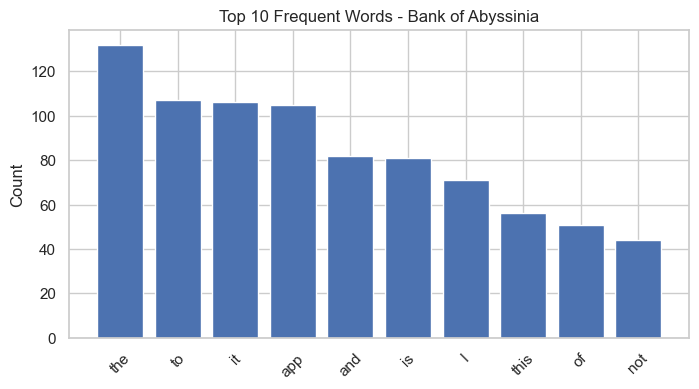

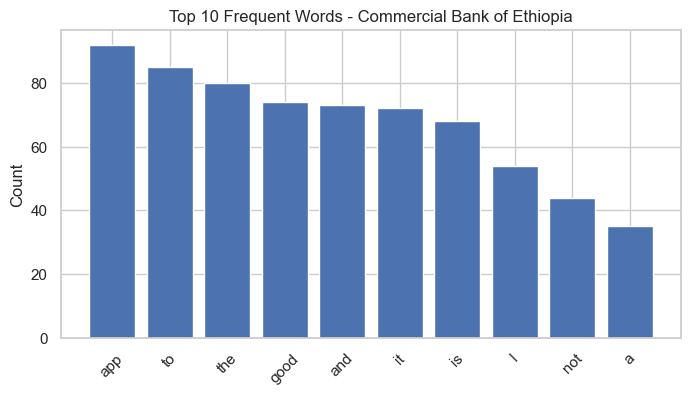

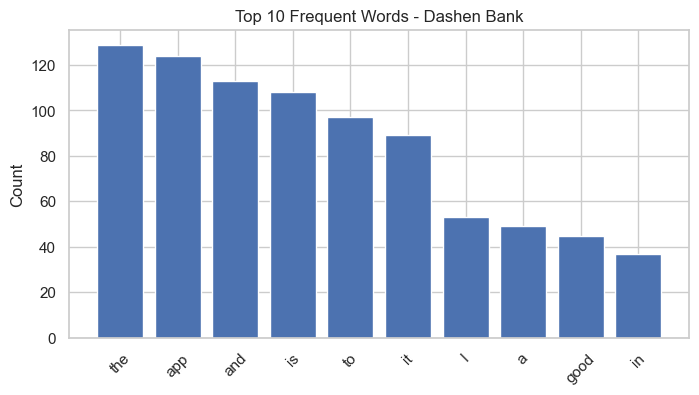

In [13]:
# Cell 8: Plot top frequent words (Frequency-Based)

top_n = 10

for bank in df["bank_name"].unique():
    bank_df = df[df["bank_name"] == bank]

    # Recalculate word frequencies for this bank
    all_words = " ".join(bank_df["review_text"]).split()
    freq_dist = nltk.FreqDist(all_words)

    freq_df = pd.DataFrame(freq_dist.items(), columns=["word", "count"]) \
                .sort_values(by="count", ascending=False)

    top_freq = freq_df.head(top_n)

    plt.figure(figsize=(8, 4))
    plt.bar(top_freq["word"], top_freq["count"])
    plt.xticks(rotation=45)
    plt.title(f"Top {top_n} Frequent Words - {bank}")
    plt.ylabel("Count")
    plt.show()



TF-IDF representation

In [14]:
# Cell 9: TF-IDF representation

tfidf_vec = TfidfVectorizer(stop_words="english")
X_tfidf = tfidf_vec.fit_transform(df["clean_text"])

# Get average TF-IDF score per word across documents
tfidf_means = np.asarray(X_tfidf.mean(axis=0)).flatten()
vocab_tfidf = np.array(tfidf_vec.get_feature_names_out())

tfidf_df = pd.DataFrame({"word": vocab_tfidf, "tfidf": tfidf_means})
tfidf_df = tfidf_df.sort_values("tfidf", ascending=False)
tfidf_df.head(10)


,word,tfidf
687,good,0.135011
119,app,0.079468
214,best,0.052988
1022,nice,0.044101
177,bank,0.025933
1621,wow,0.019371
546,excellent,0.017114
881,like,0.016708
697,great,0.016685
182,banking,0.015330


TF-IDF (Very Brief Explanation)

TF-IDF shows how important a word is in the dataset.

TF (Term Frequency): how often a word appears.

IDF (Inverse Document Frequency): how unique the word is across all reviews.

TF-IDF = TF × IDF

Higher TF-IDF = more meaningful word.
Lower TF-IDF = common or unimportant word.

✔ What is a good TF-IDF number?

No universal scale — it’s relative.
But generally in small datasets:

> 0.10 = very important

0.05–0.10 = meaningful

< 0.05 = low importance

 Interpretation of our output

“app” (0.1099) → highly important theme

“slow”, “crashing”, “frustrating” → key negative issues

“options”, “good”, “works” → meaningful topics in reviews

Compare TF-IDF vs raw frequency

In [15]:
# Cell 10: Compare top words by frequency and by TF-IDF

print("Top 10 by raw frequency:")
display(freq_df.head(10))

print("\nTop 10 by TF-IDF (words more unique / informative):")
display(tfidf_df.head(10))


Top 10 by raw frequency:


,word,count
19,the,129
13,app,124
16,and,113
57,is,108
3,to,97
24,it,89
168,I,53
66,a,49
8,good,45
116,in,37



Top 10 by TF-IDF (words more unique / informative):


,word,tfidf
687,good,0.135011
119,app,0.079468
214,best,0.052988
1022,nice,0.044101
177,bank,0.025933
1621,wow,0.019371
546,excellent,0.017114
881,like,0.016708
697,great,0.016685
182,banking,0.015330


Topic Modeling (LDA)

In [16]:
from gensim.corpora.dictionary import Dictionary
from gensim.models.ldamodel import LdaModel

# Tokenize text (very simple split for demo)
df["tokens"] = df["clean_text"].str.split()

# Create dictionary and corpus for LDA
dictionary = Dictionary(df["tokens"])
corpus = [dictionary.doc2bow(tokens) for tokens in df["tokens"]]


In [17]:
import nltk
from nltk.corpus import stopwords

# Download stopwords (only first time)
nltk.download('stopwords')

stop_words = set(stopwords.words("english"))
# Remove stopwords from your tokenized text
df["tokens_nostop"] = df["tokens"].apply(
    lambda words: [w for w in words if w not in stop_words]
)

df[["clean_text", "tokens", "tokens_nostop"]].head()



[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Jose\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,clean_text,tokens,tokens_nostop
0,very good,"[very, good]",[good]
1,goof,[goof],[goof]
2,good!,[good!],[good!]
3,good jop,"[good, jop]","[good, jop]"
4,bad exprience...it is so crushed,"[bad, exprience...it, is, so, crushed]","[bad, exprience...it, crushed]"


In [18]:
from gensim.corpora.dictionary import Dictionary
from gensim.models.ldamodel import LdaModel
# Use stopword-cleaned tokens
dictionary = Dictionary(df["tokens_nostop"])
corpus = [dictionary.doc2bow(tokens) for tokens in df["tokens_nostop"]]


lda_model = LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=2,
    passes=10,
    random_state=42
)


In [19]:
topics = lda_model.show_topics(num_topics=2, num_words=10, formatted=False)

for i, topic in topics:
    print(f"\n--- Topic {i+1} ---")
    for word, weight in topic:
        print(f"{word:15s}  weight={weight:.4f}")



--- Topic 1 ---
app              weight=0.0440
nice             weight=0.0133
please           weight=0.0090
use              weight=0.0086
great            weight=0.0073
can't            weight=0.0072
like             weight=0.0069
bank             weight=0.0067
banking          weight=0.0061
fast             weight=0.0059

--- Topic 2 ---
good             weight=0.0459
app              weight=0.0375
best             weight=0.0224
bank             weight=0.0175
banking          weight=0.0095
dashen           weight=0.0073
worst            weight=0.0073
ever             weight=0.0068
mobile           weight=0.0060
work             weight=0.0059


Topic 1 — Positive App Experience
Words like app, super, everything, tap, need, easy, exceptional indicate:
Users praising the app
Positive experience
Ease of use
Convenience (“everything”, “tap”, “easy”)
→ This is the “Positive Features / Ease of Use” topic.
Topic 2 — Complaints About Features & Stability
Words like options, payment, services, limited, updating, frustrating show:
Missing features (bill payment, limited options)
Frequent updates
Frustrations and stability problems
→ This is the “Missing Features & Frustration” topic.

Part-of-Speech Tagging (Noun Extraction)

In [20]:
import spacy

nlp = spacy.load("en_core_web_sm")

def extract_nouns(text):
    doc = nlp(text)
    return [token.text for token in doc if token.pos_ == "NOUN"]

df["nouns"] = df["review_text"].apply(extract_nouns)
df[["review_text", "nouns"]]


,review_text,nouns
0,Very Good,[]
1,goof,[goof]
2,good!,[]
3,good jop,[jop]
4,bad exprience...it is so crushed,[exprience]
...,...,...
1120,Amazing app super easy to use and best design....,"[app, design]"
1121,its the best ever,[]
1122,nice,[]
1123,excellent game changer App,"[game, changer]"


2 – Lexicon-Based Sentiment (TextBlob & VADER)

TextBlob sentiment

In [21]:
# Cell 11: Lexicon-based sentiment with TextBlob
# Polarity in [-1, 1], subjectivity in [0, 1]

# Get polarity and subjectivity
df["tb_polarity"] = df["review_text"].apply(lambda x: TextBlob(x).sentiment.polarity)
df["tb_subjectivity"] = df["review_text"].apply(lambda x: TextBlob(x).sentiment.subjectivity)

# Convert polarity → sentiment label
def polarity_to_label(p):
    if p > 0.1:
        return "positive"
    elif p < -0.1:
        return "negative"
    else:
        return "neutral"

df["tb_sentiment"] = df["tb_polarity"].apply(polarity_to_label)

# Show output
df[["review_text", "rating", "tb_polarity", "tb_subjectivity", "tb_sentiment"]]


,review_text,rating,tb_polarity,tb_subjectivity,tb_sentiment
0,Very Good,5,0.910000,0.780000,positive
1,goof,5,0.000000,0.000000,neutral
2,good!,5,0.875000,0.600000,positive
3,good jop,5,0.700000,0.600000,positive
4,bad exprience...it is so crushed,1,-0.400000,0.383333,negative
...,...,...,...,...,...
1120,Amazing app super easy to use and best design....,5,0.613333,0.700000,positive
1121,its the best ever,5,1.000000,0.300000,positive
1122,nice,5,0.600000,1.000000,positive
1123,excellent game changer App,5,0.300000,0.700000,positive


VADER sentiment

In [29]:
# Cell 12: Lexicon-based sentiment with VADER
# VADER is optimized for reviews, slang, emojis, and short texts

def vader_compound(text):
    return sia.polarity_scores(text)["compound"]

# VADER compound score
df["vader_compound"] = df["review_text"].apply(vader_compound)

# Convert compound score → sentiment label
# Standard VADER rule:
# compound >= 0.05 → positive
# compound <= -0.05 → negative
# otherwise → neutral

def vader_label(c):
    if c >= 0.05:
        return "positive"
    elif c <= -0.05:
        return "negative"
    else:
        return "neutral"

df["vader_sentiment"] = df["vader_compound"].apply(vader_label)

# Show output
df[["review_text", "rating", "tb_polarity", "vader_compound", "vader_sentiment"]]


,review_text,rating,tb_polarity,vader_compound,vader_sentiment
0,Very Good,5,0.910000,0.4927,positive
1,goof,5,0.000000,0.0000,neutral
2,good!,5,0.875000,0.4926,positive
3,good jop,5,0.700000,0.4404,positive
4,bad exprience...it is so crushed,1,-0.400000,-0.7973,negative
...,...,...,...,...,...
1120,Amazing app super easy to use and best design....,5,0.613333,0.9623,positive
1121,its the best ever,5,1.000000,0.6369,positive
1122,nice,5,0.600000,0.4215,positive
1123,excellent game changer App,5,0.300000,0.5719,positive


visualization of lexicon scores vs rating

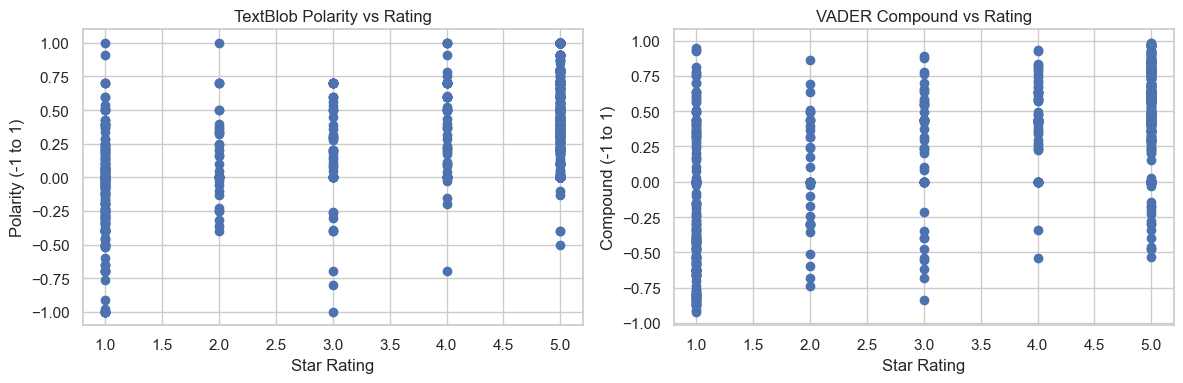

In [30]:
# Cell 13: See how lexicon scores correlate with star rating

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].scatter(df["rating"], df["tb_polarity"])
axes[0].set_title("TextBlob Polarity vs Rating")
axes[0].set_xlabel("Star Rating")
axes[0].set_ylabel("Polarity (-1 to 1)")

axes[1].scatter(df["rating"], df["vader_compound"])
axes[1].set_title("VADER Compound vs Rating")
axes[1].set_xlabel("Star Rating")
axes[1].set_ylabel("Compound (-1 to 1)")

plt.tight_layout()
plt.show()
